# Objective: properly format the annotations from the EPIC dataset to match the video file
 The metadata associated with the EPIC data does not preperly match the video, it would need some redistribution and reformatting in order to obtain better results from a deep learning model.

In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d


## Extracting all the frames from the videos
* Also had to remove the first and the last frames (with `frames_paths[1:-1]` ) from the list because they were corrupt

In [2]:
def video_to_frames(video_path, main_folder_path, sub_folder_path, size = (256,256)):
    frames_paths = []
    try:
        os.mkdir(main_folder_path + "/" + sub_folder_path)

    except:
        shutil.rmtree(main_folder_path + "/" + sub_folder_path)
        os.mkdir(main_folder_path + "/" + sub_folder_path)
        
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = main_folder_path + "/"+ sub_folder_path + "/" + str(count)+ ".jpg"
#         print(fmt_name)
        try:     
#             image_gray = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
#             image_gray_resized = cv2.resize(image_gray, size)
#             cv2.imwrite(fmt_name, image_gray_resized)
            frames_paths.append(fmt_name)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", main_folder_path + "/" + sub_folder_path)
    return np.array(frames_paths)

In [181]:
frames_folder = "frames"

target_path = "videos/20089219_unc-130_9E1_8_L2.mov"
frames_paths = video_to_frames(
                                video_path = target_path,
                                main_folder_path = frames_folder,
                                sub_folder_path = target_path[7:-4]
                               )
frames_paths = frames_paths[1:-1]
print("after removing bad frames in the beginning and the end : ", len(frames_paths))

saved  242  frames at  frames/20089219_unc-130_9E1_8_L2
after removing bad frames in the beginning and the end :  241


## Some metadata from the website that would be useful
* Imaged Timepoints = 244
* Edited Timepoints = 130

So this means that there are 130 possible time values distributed  among the 244 frames in the video. Therefore we have to now distribute 24 frames among the 130 time stamps. 

In [182]:
df = pd.read_csv("zipped_CD_Files/CD20089219_unc-130_9E1_8_L2.csv")
time_vals = df.time.unique()
df.head(5)

,cellTime,cell,time,none,global,local,blot,cross,z,x,y,size,gweight
0,AB:1,AB,1,27095,2095,-990,-990,2095,11.9,243,261,80,1559363
1,ABa:2,ABa,2,27264,2264,-1026,-1056,2264,11.1,234,281,52,474291
2,ABa:3,ABa,3,27796,2796,-465,-465,2796,11.0,216,262,58,546495
3,ABa:4,ABa,4,27428,2428,-1129,-1129,2428,11.3,212,274,60,549867
4,ABa:5,ABa,5,26827,1827,-992,-992,1827,12.1,195,277,58,500943


## Viewing the new distribution
Since 244 / 130 is approximately 2, so there are 2 frames per time stamp mostly 

In [3]:
def uniform_chop_list(frames_paths, max_time):
    num_frames = len(frames_paths)
    interp = interp1d([0,num_frames], [0, max_time])
    indices = []
    for i in range(num_frames):
        indices.append(int(interp(i)))
    final_2d = []
    
    for i in range(max_time):
        row = []
        for j in indices:
            if j == i:
                row.append(frames_paths[i])
        final_2d.append(row)
        
    return final_2d

In [184]:
chopped_paths = uniform_chop_list(frames_paths, len(time_vals))

In [185]:
chopped_paths[19:26]

[['frames/20089219_unc-130_9E1_8_L2/20.jpg',
  'frames/20089219_unc-130_9E1_8_L2/20.jpg'],
 ['frames/20089219_unc-130_9E1_8_L2/21.jpg'],
 ['frames/20089219_unc-130_9E1_8_L2/22.jpg',
  'frames/20089219_unc-130_9E1_8_L2/22.jpg'],
 ['frames/20089219_unc-130_9E1_8_L2/23.jpg'],
 ['frames/20089219_unc-130_9E1_8_L2/24.jpg',
  'frames/20089219_unc-130_9E1_8_L2/24.jpg'],
 ['frames/20089219_unc-130_9E1_8_L2/25.jpg'],
 ['frames/20089219_unc-130_9E1_8_L2/26.jpg',
  'frames/20089219_unc-130_9E1_8_L2/26.jpg']]

## Loading up the original annotations which can be found [here](http://epic.gs.washington.edu/details/ceh-32.html)

In [4]:
def generate_compact_cellnames(cellname_column_values, size = 1):
    c = []
    for i in cellname_column_values:
        short = i[:size]
        c.append(short)
    return c 

def slice_df_wrt_cellname(df, compact_cellname):
    df_slice = df[df["compact_cellname"] == compact_cellname]
    return df_slice

## Adding a new column `compact_cellname`
 `compact_cellname` would give us info about the cell’s lineage (or the name of the cell itself, depending on the value of time) and not necessarily it’s precise name.`

In [187]:
df["compact_cellname"] = generate_compact_cellnames(df["cell"].values)
df.head()

,cellTime,cell,time,none,global,local,blot,cross,z,x,y,size,gweight,compact_cellname
0,AB:1,AB,1,27095,2095,-990,-990,2095,11.9,243,261,80,1559363,A
1,ABa:2,ABa,2,27264,2264,-1026,-1056,2264,11.1,234,281,52,474291,A
2,ABa:3,ABa,3,27796,2796,-465,-465,2796,11.0,216,262,58,546495,A
3,ABa:4,ABa,4,27428,2428,-1129,-1129,2428,11.3,212,274,60,549867,A
4,ABa:5,ABa,5,26827,1827,-992,-992,1827,12.1,195,277,58,500943,A


## Finding the population of each cell family at a given time 
* `find_num_cells_with_time()` is pretty self explanatory, finds the number of cells for all possible time values in the dataset
*  `generate_cell_wise_population_plots()`generates a 2D array with the time values and the respective lineage population for each cell family 

In [5]:
def find_num_cells(df, time_val):
    df_time = df[df["time"] == time_val]
    return len(df_time.cell.unique())

def find_num_cells_with_time(df):
    times = df.time.unique()
    num_cells = [find_num_cells(df, time) for time in times]
    
    return times, num_cells # x, y axis 

def generate_cell_wise_population_plots(df):
    compact_cellnames = df["compact_cellname"].unique()
    plots =  []
    for name in compact_cellnames:
        sliced_df = slice_df_wrt_cellname(df, compact_cellname = name)

        times , num_cells = find_num_cells_with_time(sliced_df)
        plots.append([times, num_cells])
    return np.array(plots)

In [189]:
plots = generate_cell_wise_population_plots(df)

## Plotting the population with respect to time 

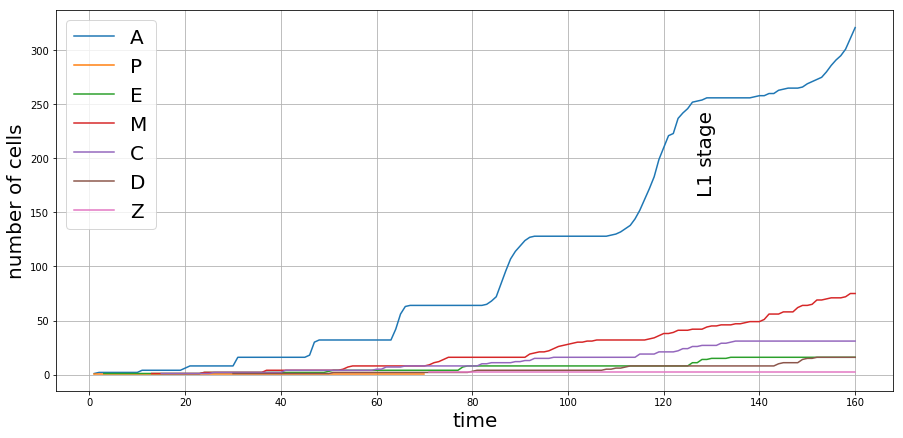

In [190]:
plt.rcParams['figure.figsize'] =15, 7

compact_cellnames = df["compact_cellname"].unique()

for i in range (len(plots)):
    plt.plot(plots[i][0], plots[i][1], label = compact_cellnames[i] )

    
plt.grid()
# plt.axvline(x = 200, linestyle = "--", color = "red")
plt.text(x = 127, y = 230, s = 'L1 stage',rotation=90, fontsize = 20)
plt.legend(fontsize = 20)
plt.xlabel("time", fontsize = 20)
plt.ylabel("number of cells", fontsize = 20)
plt.show()

In [191]:
compact_cellnames

array(['A', 'P', 'E', 'M', 'C', 'D', 'Z'], dtype=object)

In [192]:
populations = [pop[1] for pop in plots]
ideal_len = len(populations[0])

for i in range (len(populations)):
    row = populations[i]
    
    while len(row) <= ideal_len:
        row.insert(0,0)
    populations[i] = row
    
populations = np.array(populations)
print(populations.shape)

(7, 161)


## Transposing the data to get the population of each family with time 
This would be a much better format for deep learning models to train upon

In [193]:
pop_transpose = np.transpose(populations)
print ("shape = ", pop_transpose.shape)
pop_transpose[:5]

shape =  (161, 7)


array([[0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0],
       [2, 0, 1, 0, 0, 0, 0],
       [2, 0, 1, 0, 0, 0, 0]])

In [194]:
final_data= []
for i in range(len(chopped_paths)):
    row = chopped_paths[i]
    for name in row:
        data_row = pop_transpose[i]
        final_data.append(data_row)
final_data = np.array(final_data)

In [195]:
filenames  = pd.DataFrame(frames_paths)
# print(filenames.head())
filenames.columns = ["filenames"]

train_df = pd.DataFrame(final_data)
train_df.columns = compact_cellnames

train_df = pd.concat([filenames, train_df], axis = 1)
train_df.head(10)

,filenames,A,P,E,M,C,D,Z
0,frames/20089219_unc-130_9E1_8_L2/1.jpg,0,0,0,0,0,0,0
1,frames/20089219_unc-130_9E1_8_L2/2.jpg,0,0,0,0,0,0,0
2,frames/20089219_unc-130_9E1_8_L2/3.jpg,1,0,0,0,0,0,0
3,frames/20089219_unc-130_9E1_8_L2/4.jpg,1,0,0,0,0,0,0
4,frames/20089219_unc-130_9E1_8_L2/5.jpg,2,0,0,0,0,0,0
5,frames/20089219_unc-130_9E1_8_L2/6.jpg,2,0,1,0,0,0,0
6,frames/20089219_unc-130_9E1_8_L2/7.jpg,2,0,1,0,0,0,0
7,frames/20089219_unc-130_9E1_8_L2/8.jpg,2,0,1,0,0,0,0
8,frames/20089219_unc-130_9E1_8_L2/9.jpg,2,0,1,0,0,0,0
9,frames/20089219_unc-130_9E1_8_L2/10.jpg,2,0,1,0,0,0,0


## Scale up for multiple video files 
* Basically the same process as above but in one single function 

In [7]:
def video_csv_pairs_to_training_data(video_path,csv_path, main_foldername, drop_first_last_frame = True):
    
    df = pd.read_csv(csv_path)
    
    df["compact_cellname"] = generate_compact_cellnames(df["cell"].values)
    compact_cellnames = df["compact_cellname"].unique()
    sub_foldername = video_path[7:-4]
#     print(sub_foldername)
    
    
    if len(compact_cellnames) == 7:
        
        
        frames_paths = video_to_frames(
                                video_path = video_path,
                                main_folder_path = main_foldername,
                                sub_folder_path = sub_foldername
                               )
        if drop_first_last_frame == True:
            frames_paths = frames_paths[1:-1]
            
            
        times = df.time.unique()
        num_chops = len(times)
        chopped_paths = uniform_chop_list(frames_paths = frames_paths, max_time = num_chops)
        
        plots = generate_cell_wise_population_plots(df)

        populations = [pop[1] for pop in plots]
        ideal_len = len(populations[0])

        for i in range (len(populations)):
            row = populations[i]

            while len(row) <= ideal_len:
                row.insert(0,0)
            populations[i] = row

        populations = np.array(populations)
        pop_transpose = np.transpose(populations)

        final_data= []
        for i in range(len(chopped_paths)):
            row = chopped_paths[i]
            for name in row:
                data_row = pop_transpose[i]
                final_data.append(data_row)
        final_data = np.array(final_data)    

        filenames  = pd.DataFrame(frames_paths)
        filenames.columns = ["filenames"]

        train_df = pd.DataFrame(final_data)
#         print(compact_cellnames)
        train_df.columns = compact_cellnames

        train_df = pd.concat([filenames, train_df], axis = 1)
#         print(train_df.head())

        return train_df
    else:
        print(" \n skipped ", csv_path, "because it doesn't contain all the cell lineages \n")
        return None

In [8]:
def mass_conversion_to_frames_and_build_training_data(videos_folder, csv_folder, frames_foldername, train_tag = "L1"):
    videos = os.listdir(videos_folder)
    ids = [i[:-4] for i in videos]
    
    dfs = []
    
    for i in tqdm(range(len(ids))):
        
        csv_filename = csv_folder + "/" + "CD" + ids[i] + ".csv"
        video_filename = videos_folder + "/" + ids[i] + ".mov"
        
        try:
            df = video_csv_pairs_to_training_data(video_path = video_filename,
                                             csv_path = csv_filename, 
                                             main_foldername = frames_foldername)
        except:
            print(" \n **********         error occurred, skipping...        ********* \n ")
        if df is not None:
            dfs.append(df)
    return dfs

In [ ]:
!rm -rf frames/* 
dfs = mass_conversion_to_frames_and_build_training_data(videos_folder = "videos",
                                                  csv_folder = "zipped_CD_Files",
                                                  frames_foldername = "frames")

## Concatenating the data for the 2 different files that were processed and saving them /


In [10]:
final_df = pd.concat(dfs, axis = 0, sort = False)
print(final_df.info())
final_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62667 entries, 0 to 244
Data columns (total 8 columns):
filenames    62667 non-null object
A            62667 non-null int64
E            62667 non-null int64
M            62667 non-null int64
P            62667 non-null int64
C            62667 non-null int64
D            62667 non-null int64
Z            62667 non-null int64
dtypes: int64(7), object(1)
memory usage: 4.3+ MB
None


,filenames,A,E,M,P,C,D,Z
0,frames/20091023_dpy-31_3_L2/1.jpg,0,0,0,0,0,0,0
1,frames/20091023_dpy-31_3_L2/2.jpg,0,0,0,0,0,0,0
2,frames/20091023_dpy-31_3_L2/3.jpg,2,0,0,0,0,0,0
3,frames/20091023_dpy-31_3_L2/4.jpg,2,0,0,0,0,0,0
4,frames/20091023_dpy-31_3_L2/5.jpg,2,0,0,0,0,0,0


In [11]:
final_df.to_csv("data/training_data.csv", index = False)

In [ ]:
!zip -r frames_raw.zip frames/